# Практическая работа: обнаружение бродячих собак vs собак на поводке

### Блок 1: Импорты

В этом блоке:
- импортируем библиотеки для работы с изображениями, визуализацией и запросами;
- подключаем `supervision` для работы с детекциями и аннотациями;
- подключаем `InferenceHTTPClient` для вызова Roboflow Workflow.


In [2]:
import os
import base64
import cv2
import numpy as np
import requests
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
from collections import Counter

import supervision as sv
from inference_sdk import InferenceHTTPClient


### Блок 2: Конфигурация

В этом блоке задаём параметры эксперимента:
- адрес Roboflow Serverless API;
- имя workspace и workflow;
- API-ключ (лучше через переменную окружения);
- пороги `CONF_THRESHOLD` и `IOU_THRESHOLD`, которые влияют на чувствительность и подавление дублей (NMS).


In [3]:

API_URL = "https://serverless.roboflow.com"
WORKSPACE_NAME = "skarsakov"
WORKFLOW_ID = "find-stray-dogs-and-pet-on-leashes"

API_KEY = os.getenv("ROBOFLOW_API_KEY", "86jPqA6SxQ0bodu6Iz8p")

# Порог уверенности и IoU для отрисовки/фильтрации
CONF_THRESHOLD = 0.5
IOU_THRESHOLD = 0.6


### Блок 3: Вспомогательные функции

В этом блоке описываем и реализуем вспомогательные функции, которые будут использоваться в следующих шагах:
- загрузка изображения из URL/файла в `numpy` (RGB);
- парсинг ответа Roboflow Workflow в `sv.Detections` + базовый NMS;
- постобработка `simple_filter` (удаление некорректных/вложенных боксов);
- генерация текстовой сводки и отрисовка боксов на изображении.


In [5]:
def load_image(url_or_path: str) -> np.ndarray:
    """Загружает изображение из URL или локального пути и возвращает numpy-массив в RGB."""
    if url_or_path.startswith("http"):
        response = requests.get(url_or_path, timeout=15)
        response.raise_for_status()
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        with open(url_or_path, "rb") as f:
            image = Image.open(BytesIO(f.read())).convert("RGB")
    return np.array(image)


def to_image_input(url_or_path: str) -> dict:
    """Готовит вход для workflow: URL как есть, локальный файл -> base64."""
    if url_or_path.startswith("http"):
        return {"type": "url", "value": url_or_path}
    with open(url_or_path, "rb") as f:
        encoded = base64.b64encode(f.read()).decode("utf-8")
    return {"type": "base64", "value": encoded}


def workflow_result_to_detections(result, conf_threshold: float = CONF_THRESHOLD) -> sv.Detections:
    """Преобразует ответ workflow в sv.Detections, используя from_inference.
    Ожидаемый формат: список с одним dict, внутри ключ "predictions": {"image":..., "predictions": [...]}.
    """
    if isinstance(result, list) and result and isinstance(result[0], dict):
        prediction_data = result[0]
    elif isinstance(result, dict):
        prediction_data = result
    else:
        return sv.Detections.empty()

    # Roboflow format: prediction_data["predictions"] -> {"image":..., "predictions": [...]}
    preds_container = prediction_data.get("predictions")
    if not isinstance(preds_container, dict):
        return sv.Detections.empty()

    detections = sv.Detections.from_inference(preds_container)

    # Фильтр по confidence
    keep = detections.confidence >= conf_threshold
    detections = detections[keep]
    # NMS class-agnostic
    detections = detections.with_nms(threshold=IOU_THRESHOLD, class_agnostic=True)
    return detections


def simple_filter(
    detections: sv.Detections,
    min_rel_area: float = 0.015,
    overlap_keep_class: str = "pet on leash",
    overlap_drop_class: str = "stray dog",
    overlap_iou: float = 0.55,
    contain_ratio: float = 0.7,
    image_shape: tuple[int, int] | None = None,
) -> sv.Detections:
    """Лёгкая постобработка без падений.
    - Отсекает слишком мелкие боксы (площадь < min_rel_area кадра).
    - Если есть пересечение keep/drop с IoU >= overlap_iou — убираем drop.
    - Если drop почти целиком внутри keep (inter_area / area_drop >= contain_ratio) — убираем drop.
    - Если один pet on leash вложен в другой (inter_area / площадь меньшего >= contain_ratio) — убираем меньший.
    """
    if len(detections) == 0 or image_shape is None:
        return detections

    boxes = np.asarray(detections.xyxy, dtype=float)
    if boxes.ndim != 2 or boxes.shape[1] != 4:
        return detections

    h, w = image_shape
    areas = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    keep_area = areas / (w * h) >= min_rel_area
    det = detections[keep_area]

    if len(det) <= 1:
        return det

    cls = det.data.get("class_name", [])
    if not isinstance(cls, (list, np.ndarray)) or len(cls) != len(det):
        return det

    boxes_det = np.asarray(det.xyxy, dtype=float)
    if boxes_det.ndim != 2 or boxes_det.shape[1] != 4:
        return det

    areas_det = (boxes_det[:, 2] - boxes_det[:, 0]) * (boxes_det[:, 3] - boxes_det[:, 1])

    to_drop = set()
    for i in range(len(det)):
        for j in range(i + 1, len(det)):
            b_i = boxes_det[i]
            b_j = boxes_det[j]
            if b_i.shape != (4,) or b_j.shape != (4,):
                continue
            # IoU между боксами
            iou_val = sv.box_iou(b_i, b_j)
            iou = float(np.squeeze(iou_val)) if isinstance(iou_val, np.ndarray) else float(iou_val)

            # 1) Убираем drop-класс при сильном перекрытии с keep-классом
            if iou >= overlap_iou:
                if cls[i] == overlap_keep_class and cls[j] == overlap_drop_class:
                    to_drop.add(j)
                    continue
                elif cls[j] == overlap_keep_class and cls[i] == overlap_drop_class:
                    to_drop.add(i)
                    continue
                elif cls[i] == overlap_keep_class and cls[j] == overlap_keep_class:
                    # Убираем меньший при сильном IoU (даже без полной вложенности)
                    drop_idx = j if areas_det[i] >= areas_det[j] else i
                    to_drop.add(drop_idx)
                    continue

            # Проверка вложенности (даже при низком IoU)
            x1 = max(b_i[0], b_j[0]); y1 = max(b_i[1], b_j[1])
            x2 = min(b_i[2], b_j[2]); y2 = min(b_i[3], b_j[3])
            inter_w = max(0.0, x2 - x1)
            inter_h = max(0.0, y2 - y1)
            inter_area = inter_w * inter_h
            if inter_area <= 0:
                continue

            # Для keep/drop: убираем drop, если он сильно покрыт
            if cls[i] == overlap_keep_class and cls[j] == overlap_drop_class:
                if inter_area / max(areas_det[j], 1e-6) >= contain_ratio:
                    to_drop.add(j)
            elif cls[j] == overlap_keep_class and cls[i] == overlap_drop_class:
                if inter_area / max(areas_det[i], 1e-6) >= contain_ratio:
                    to_drop.add(i)
            # Для keep/keep: убираем меньший, если он сильно покрыт
            elif cls[i] == overlap_keep_class and cls[j] == overlap_keep_class:
                min_area = min(areas_det[i], areas_det[j])
                if inter_area / max(min_area, 1e-6) >= contain_ratio:
                    drop_idx = j if areas_det[i] >= areas_det[j] else i
                    to_drop.add(drop_idx)

    if to_drop:
        keep_idx = [k for k in range(len(det)) if k not in to_drop]
        det = det[keep_idx]

    return det


def build_summary_message(detections: sv.Detections) -> str:
    """Формирует текстовый вывод по количеству и типам объектов."""
    total_count = len(detections)
    if total_count == 0:
        return "Бродячих собак или собак на поводке не обнаружено."

    classes = detections.data.get("class_name", [])
    counter = Counter(classes)
    most_common_class, most_common_count = counter.most_common(1)[0]
    counts_str = ", ".join([f"{cls}: {cnt}" for cls, cnt in counter.items()])
    return (
        f"Обнаружено объектов: {total_count} (по классам: {counts_str}). "
        f"Чаще всего встречается: {most_common_class} ({most_common_count})."
    )


def annotate_and_show(image_np: np.ndarray, detections: sv.Detections, title: str = "") -> None:
    """Отрисовывает боксы и метки, выводит изображение и текстовую сводку.
    BoxAnnotator/LabelAnnotator ждут BGR, поэтому конвертируем туда-обратно.
    (Кейс без детекций не обрабатываем — по условию их не будет.)
    """
    summary_text = build_summary_message(detections)
    print(summary_text)

    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()

    labels = [
        f"{cls} {conf:.2f}"
        for cls, conf in zip(detections.data.get("class_name", []), detections.confidence)
    ]

    image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    annotated_bgr = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
    annotated_bgr = label_annotator.annotate(scene=annotated_bgr, detections=detections, labels=labels)
    annotated_rgb = cv2.cvtColor(annotated_bgr, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 8))
    plt.title(title)
    plt.imshow(annotated_rgb)
    plt.axis('off')
    plt.show()


### Блок 4: Тестовые изображения

В этом блоке:
- задаём 4 тестовых изображения (URL): 2 примера с поводком и 2 примера с бродячими;
- проверяем, что ссылки корректные (начинаются с `http`).


In [6]:
test_images = {
    "stray_1": "https://www.kp40.ru/thumbnails/153123/845x0.webp",
    "leash_1": "https://ir.ozone.ru/s3/multimedia-1-j/6969675115.jpg",
    "leash_2": "https://www.europafm.ro/wp-content/uploads/2025/06/shutterstock_2578471705-scaled.jpg",
    "stray_2": "https://static.mk.ru/upload/entities/2023/05/16/19/articles/facebookPicture/b4/0d/60/70/7156bdcb6b0be75ab58638437992f0b9.jpg",
}

assert all(url.startswith("http") for url in test_images.values()), "URL должен начинаться с http"

### Блок 5: Инициализация клиента Roboflow

В этом блоке:
- создаём `InferenceHTTPClient` с `API_URL` и `API_KEY`;
- готовим клиент, через который будем вызывать workflow.


In [7]:
client = InferenceHTTPClient(
    api_url=API_URL,
    api_key=API_KEY,
)

print("Клиент Roboflow инициализирован")


Клиент Roboflow инициализирован


### Блок 6: Инференс (workflow) + визуализация

В этом блоке:
- для каждого тестового изображения вызываем Roboflow Workflow;
- превращаем ответ в `sv.Detections` и фильтруем по порогам (`CONF_THRESHOLD`, `IOU_THRESHOLD`);
- применяем постобработку `simple_filter`, чтобы убрать некорректные/вложенные боксы;
- рисуем боксы и подписи на изображении, а также печатаем краткую статистику.



=== stray_1 ===
Обнаружено объектов: 9 (по классам: stray dog: 9). Чаще всего встречается: stray dog (9).


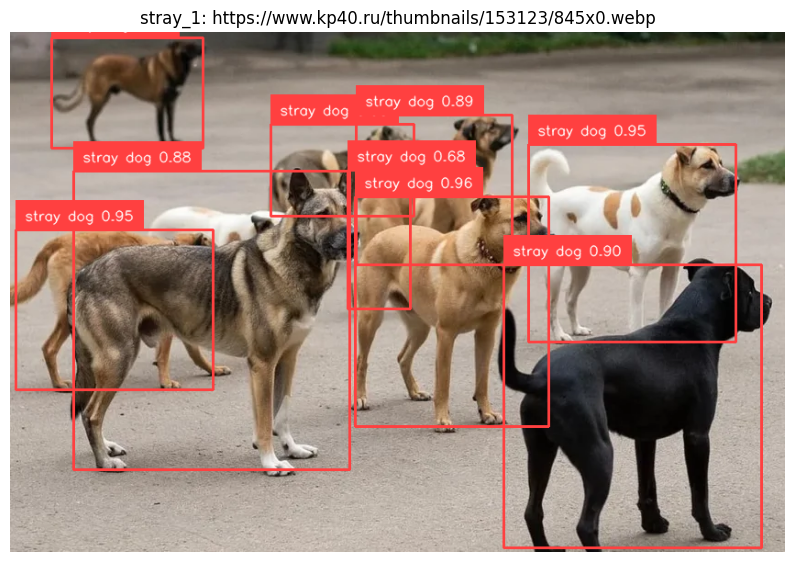


=== leash_1 ===
Обнаружено объектов: 1 (по классам: pet on leash: 1). Чаще всего встречается: pet on leash (1).


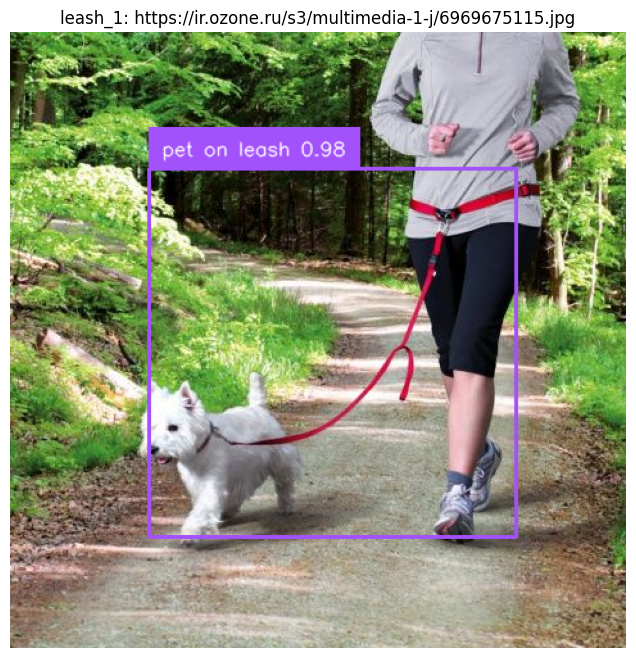


=== leash_2 ===
Обнаружено объектов: 1 (по классам: pet on leash: 1). Чаще всего встречается: pet on leash (1).


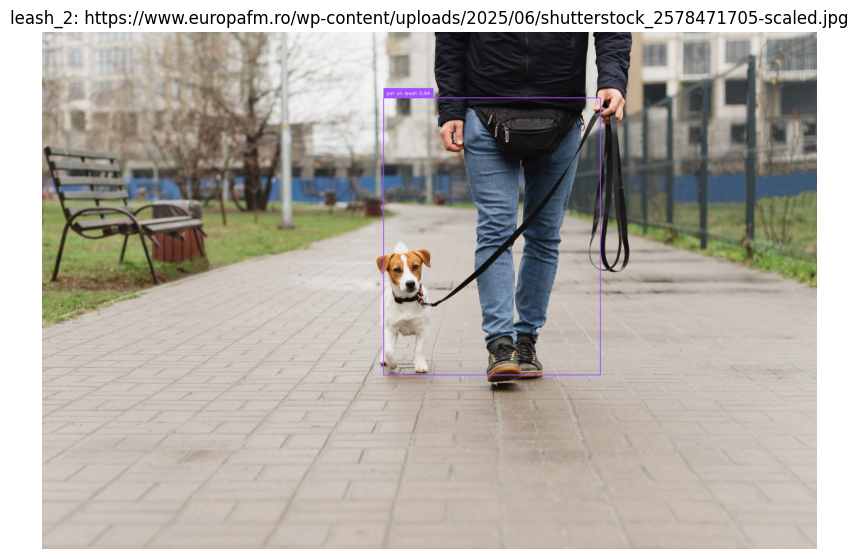


=== stray_2 ===
Обнаружено объектов: 5 (по классам: stray dog: 5). Чаще всего встречается: stray dog (5).


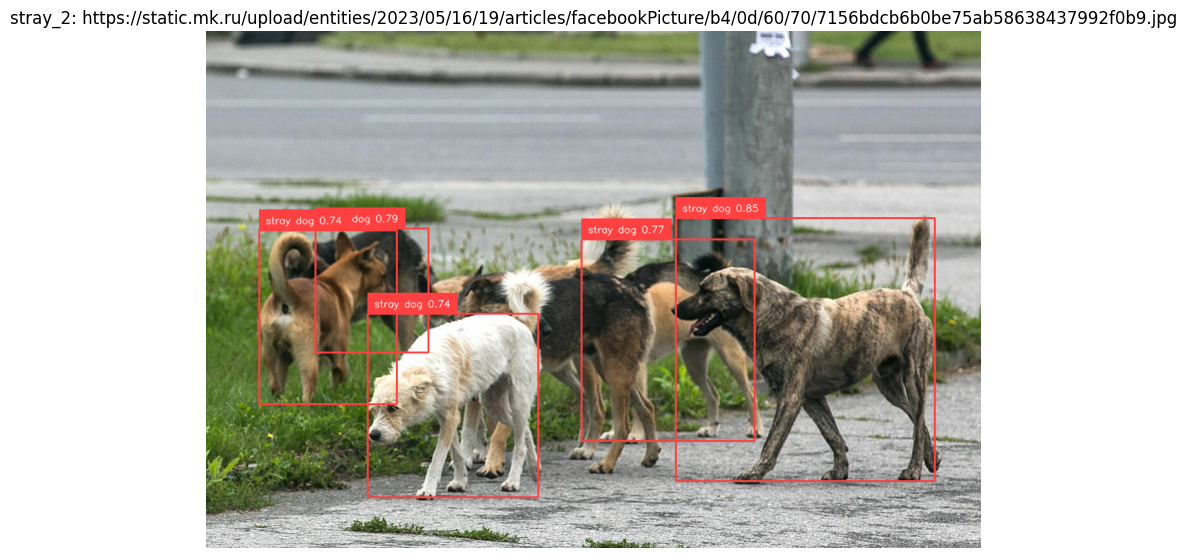


Готово: все указанные изображения обработаны.


In [8]:
# --- Блок 6: Запросы к workflow и визуализация ---
results = {}

for name, image_path in test_images.items():
    print(f"\n=== {name} ===")
    image_np = load_image(image_path)

    try:
        wf_result = client.run_workflow(
            workspace_name=WORKSPACE_NAME,
            workflow_id=WORKFLOW_ID,
            images={"image": image_path},
            use_cache=False,
        )

    except Exception as exc:
        print(f"Ошибка при вызове workflow: {exc}")
        continue

    detections = workflow_result_to_detections(wf_result, conf_threshold=CONF_THRESHOLD)
    detections = simple_filter(
        detections,
        min_rel_area=0.015,
        overlap_keep_class="pet on leash",
        overlap_drop_class="stray dog",
        overlap_iou=0.55,
        image_shape=image_np.shape[:2],
    )

    results[name] = {"raw": wf_result, "image": image_np, "detections": detections}

    annotate_and_show(image_np, detections, title=f"{name}: {image_path}")

print("\nГотово: все указанные изображения обработаны.")


### Блок 7: Итоговая сводка

В этом блоке:
- собираем результаты по всем изображениям в одну таблицу/структуру;
- считаем количество объектов по классам (`stray dog`, `pet on leash`);
- выводим человеко-читаемую сводку и предупреждения по бродячим собакам.


In [9]:
# --- Блок 7: Итоговая сводка по всем изображениям ---
summary_rows = []
for name, payload in results.items():
  detections = payload["detections"]
  counter = Counter(detections.data.get("class_name", [])) if len(detections) else {}
  summary_rows.append({
    "image": name,
    "total": len(detections),
    "by_class": dict(counter),
  })

if not summary_rows:
  print("Нет данных для сводки (см. ошибки выше).")
else:
  for row in summary_rows:
    print(f"\n=== Сводка для изображения: {row['image']} ===")
    stray_count = row['by_class'].get('stray dog', 0)
    leash_count = row['by_class'].get('pet on leash', 0)

    if stray_count > 0:
      print(f"Внимание. Опасность. Обнаружены бродячие собаки: {stray_count}")

    print(f"Собака на поводке: {leash_count}")

    if row['total'] == 0:
      print("Объектов не обнаружено.")
    elif row['total'] > stray_count + leash_count:
      other_classes = {k: v for k, v in row['by_class'].items() if k not in ['stray dog', 'pet on leash']}
      if other_classes:
        print(f"Другие классы: {other_classes}")



=== Сводка для изображения: stray_1 ===
Внимание. Опасность. Обнаружены бродячие собаки: 9
Собака на поводке: 0

=== Сводка для изображения: leash_1 ===
Собака на поводке: 1

=== Сводка для изображения: leash_2 ===
Собака на поводке: 1

=== Сводка для изображения: stray_2 ===
Внимание. Опасность. Обнаружены бродячие собаки: 5
Собака на поводке: 0
